# ADA final exam (Fall 2021)

This exam consists of 2 parts.
The first part has 3 tasks.
The second part has 2 tasks.
The two parts are completely independent of each other.

## Important: The data used for this exam **is not entirely real.** A great deal of it has been artificially created or modified. Conclusions drawn from this data have no real link to reality!

In [1]:
%matplotlib inline

# General
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For graph-related stuff
import networkx as nx

# For regression analyses and statistical tests
import scipy.stats as stats
import statsmodels.stats
import statsmodels.formula.api as smf

# For classification
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os


## Part 1 — Faculty hiring network

For the first part of the exam, you will analyze data from a faculty hiring network. After completing their Ph.D., researchers who want to pursue an academic career must compete for relatively few permanent positions (as “faculty”, i.e., professors) in a highly competitive job market. You will analyze a directed graph that captures the dynamics of this hiring process in the United States:


- Each node $u$ in this graph represents a different American university.
- For each university, we also provide a score that captures how highly  this university is ranked (e.g., Stanford University is ranked more highly than the University of Alabama). The higher the score, the more highly ranked the university.
- Each directed edge $(u,v)$ in this graph represents a hiring decision where someone who did their Ph.D. at university $u$ subsequently was hired by university $v$. Each edge is also associated with a gender label, which specifies if the person hired was a man (M) or a woman (F).
- Note that, when multiple researchers were trained at a given university $u$ and subsequently hired by university $v$, there will be multiple edges pointing from $u$ to $v$, each of which corresponds to a different person.


## Files (in the `./data/part-1/` folder)

- `nodelist.tsv` a tab-separated file containing the nodes of the graph. Recall that each node represents a different university. The file has these columns:
    - `u` — the node index;
    - `score` — the rank of the university (the higher the better);
    - `name` — the name of the university.

- `edgelist.tsv` a tab-separated file containing the edges of the graph. Recall that each edge represents a hiring decision. The file has columns:
    - `u` — the source university, where the person got their Ph.D.;
    - `v` — the target university, where the person was hired;
    - `gender` — the gender of the person.


### Task 1 — (20 points)

1. Using the above files, create the directed graph representing the hiring network using `networkx`.
Each node should contain the attributes `score` and `name`, and each edge should contain the attribute `gender`.
Print the total numbers of nodes and edges in the graph.

2. Create a plot that allows you to easily visualize **(a)** what fraction of all researchers in the graph are hired by the $N$ universities that hire the most; and  **(b)** what fraction of all researchers in the graph are trained by the $N$ universities whose students get hired the most.
Here, $N$ could be any number between 1 and the number of universities.

3. **/Multiple choice:/** Which centrality metric(s) is/are illustrated in the plot you made for the previous subtask? Select all that apply from the list below and **justify your answer.**
    1. Betweenness centrality
    2. In-degree centrality
    3. Out-degree centrality
    4. PageRank centrality

4. **/True or false:/** Search engines such as Google have historically used PageRank centrality as a signal to determine the importance of pages on the Web. Is the following statement **true** or **false**? Justify. **"In the faculty hiring network, PageRank centrality is positively correlated with university score, that is, universities with higher scores are more likely to also have higher PageRank centrality."**


#### Question 1

In [2]:
# Paths
EDGELIST_PATH = os.path.join('data', 'part-1', 'edgelist.tsv')
NODELIST_PATH = os.path.join('data', 'part-1', 'nodelist.tsv')

# Create dataframes
df_edgelist = pd.read_csv(EDGELIST_PATH, sep='\t')
df_nodelist = pd.read_csv(NODELIST_PATH, sep='\t')

In [3]:
df_edgelist

,u,v,gender
0,1,1,F
1,1,1,F
2,1,1,F
3,1,1,M
4,1,1,M
...,...,...,...
4383,194,194,M
4384,198,198,M
4385,200,200,F
4386,204,204,M


In [4]:
df_nodelist

,u,score,name
0,1,100.000000,Stanford University
1,2,99.956665,UC Berkeley
2,3,99.301230,MIT
3,4,98.369536,California Institute of Technology
4,5,97.892855,Harvard University
...,...,...,...
200,201,2.535074,Pace University
201,202,2.470072,New Mexico Institute of Mining and Technology
202,203,2.367152,"University of Nevada, Reno"
203,204,0.016250,"University of Alabama, Tuscaloosa"


In [5]:
# Get nodes attributes
attrs = df_nodelist.set_index('u').to_dict(orient='index')
attrs

{1: {'score': 100.0, 'name': 'Stanford University'},
 2: {'score': 99.95666540274092, 'name': 'UC Berkeley'},
 3: {'score': 99.30122961919722, 'name': 'MIT'},
 4: {'score': 98.36953577812685, 'name': 'California Institute of Technology'},
 5: {'score': 97.8928552082769, 'name': 'Harvard University'},
 6: {'score': 96.71740425762418, 'name': 'Cornell University'},
 7: {'score': 96.18113861654297, 'name': 'Carnegie Mellon University'},
 8: {'score': 96.15947131791344, 'name': 'Princeton University'},
 9: {'score': 95.80196089052598, 'name': 'Yale University'},
 10: {'score': 95.2169438275283, 'name': 'University of Washington'},
 11: {'score': 93.93315638372783,
  'name': 'University of Illinois, Urbana Champaign'},
 12: {'score': 93.55939548236822, 'name': 'University of Wisconsin, Madison'},
 13: {'score': 92.91479334813933, 'name': 'University of Pennsylvania'},
 14: {'score': 92.30269216185472, 'name': 'Rice University'},
 15: {'score': 91.55517035913547, 'name': 'UCLA'},
 16: {'scor

In [6]:
# Create directed graph
G = nx.from_pandas_edgelist(df_edgelist, source='u', target='v',
                            edge_attr='gender', create_using=nx.MultiDiGraph)

# Add nodes attributes
nx.set_node_attributes(G, attrs)

In [7]:
# Show nodes and edges
nx.info(G)

'MultiDiGraph with 205 nodes and 4388 edges'

#### Question 2

In [8]:
# Number of persons
N = G.number_of_edges()
N

4388

In [9]:
# Merge edges with target nodes
df_target = df_edgelist.merge(df_nodelist, left_on='v', right_on='u').drop(
    columns='u_y').rename(columns={'u_x': 'u'})
df_target

,u,v,gender,score,name
0,1,1,F,100.00000,Stanford University
1,1,1,F,100.00000,Stanford University
2,1,1,F,100.00000,Stanford University
3,1,1,M,100.00000,Stanford University
4,1,1,M,100.00000,Stanford University
...,...,...,...,...,...
4383,139,172,M,15.55712,University of New Brunswick
4384,139,172,M,15.55712,University of New Brunswick
4385,172,172,M,15.55712,University of New Brunswick
4386,172,172,F,15.55712,University of New Brunswick


In [10]:
# Group by university and count occurences
university_target = df_target.groupby('name').size().sort_values(ascending=False)
university_target

name
Carnegie Mellon University          116
Georgia Tech                         77
MIT                                  67
University of Waterloo               63
University of Michigan               53
                                   ... 
University of Mississippi             5
Catholic University of America        4
Virginia Commonwealth University      4
Claremont Graduate University         4
CUNY Graduate Center                  2
Length: 205, dtype: int64

Text(0.5, 1.0, 'Fraction of all researchers hired by the $N$ universities that hire the most')

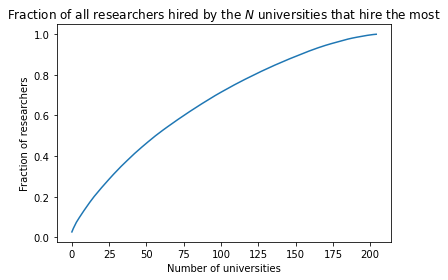

In [11]:
plt.plot((university_target.cumsum() / N).values)
plt.xlabel('Number of universities')
plt.ylabel('Fraction of researchers')
plt.title('Fraction of all researchers hired by the $N$ universities that hire the most')

In [12]:
# Merge edges with source nodes
df_source = df_edgelist.merge(df_nodelist, on='u')
df_source

,u,v,gender,score,name
0,1,1,F,100.000000,Stanford University
1,1,1,F,100.000000,Stanford University
2,1,1,F,100.000000,Stanford University
3,1,1,M,100.000000,Stanford University
4,1,1,M,100.000000,Stanford University
...,...,...,...,...,...
4383,194,194,M,4.409295,"University of Arkansas, Fayetteville"
4384,198,198,M,3.298846,Florida Institute of Technology
4385,200,200,F,2.795082,Rochester Institute of Technology
4386,204,204,M,0.016250,"University of Alabama, Tuscaloosa"


In [13]:
# Group by university and count occurences
university_source = df_source.groupby('name').size().sort_values(ascending=False)
university_source

name
MIT                                         299
UC Berkeley                                 204
Stanford University                         189
Carnegie Mellon University                  166
University of Illinois, Urbana Champaign    164
                                           ... 
University of Mississippi                     1
University of Miami                           1
University of Memphis                         1
University of Maine                           1
North Dakota State University                 1
Length: 185, dtype: int64

Text(0.5, 1.0, 'Fraction of all researchers trained by the $N$ universities whose students get hired the most')

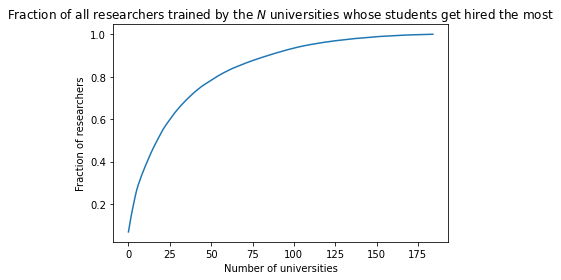

In [14]:
plt.plot((university_source.cumsum() / N).values)
plt.xlabel('Number of universities')
plt.ylabel('Fraction of researchers')
plt.title('Fraction of all researchers trained by the $N$ universities whose students get hired the most')

#### Question 3

The plots illustrate the in-degree and out-degree centrality because it shows the importance of universities, represented as nodes, in the graph. The hiring corresponds to the in-degree, and the training corresponds to the out-degree.

#### Question 4

In [15]:
# Get pagerank centrality
df_pagerank = pd.DataFrame.from_dict(nx.pagerank(G), orient='index', columns=['pagerank'])

# Merge with node list
df_nodes_merged = df_nodelist.merge(df_pagerank, left_on='u', right_index=True)
df_nodes_merged

,u,score,name,pagerank
0,1,100.000000,Stanford University,0.001795
1,2,99.956665,UC Berkeley,0.001772
2,3,99.301230,MIT,0.001738
3,4,98.369536,California Institute of Technology,0.001329
4,5,97.892855,Harvard University,0.001381
...,...,...,...,...
200,201,2.535074,Pace University,0.008257
201,202,2.470072,New Mexico Institute of Mining and Technology,0.005368
202,203,2.367152,"University of Nevada, Reno",0.005291
203,204,0.016250,"University of Alabama, Tuscaloosa",0.056965


In [16]:
# Tests non-correlation
stats.pearsonr(df_nodes_merged['score'], df_nodes_merged['pagerank'])

(-0.44113316388661317, 3.5890796110736994e-11)

The p-value is lesser than 5% and the correlation coefficient is negative. Thus, PageRank centrality is negatively correlated with university score. The answer is **False**.

### Task 2 — (15 points)

Each hiring decision $(u,v)$ connects two different universities with different scores.

1. Divide the universities into quintiles according to their scores ($Q_1$ to $Q_5$, where $Q_5$ contains the highest-ranked universities, i.e., those with the highest scores). Create a succinct plot that captures, for each pair of quintiles ($Q_i$, $Q_j$), what fraction of people in the dataset who got their Ph.D. from a university in $Q_i$ were hired by a university in $Q_j$.


2. **/Multiple choice:/** What does the plot made in the previous subtask reveal about the faculty hiring process? Select one of the following options and justify your answer.
    1. Ph.D. graduates who are hired as professors usually go to universities that are better than the universities where they were trained.
    2. Ph.D. graduates who are hired as professors usually go to universities that are around the same or worse than the universities where they were trained.

3. **/True or false:/** Let $E$ be the set of edges from the hiring network, and let $X$ be defined as follows:
$$X = \frac{|(u,v) \in E : u \in Q_1 \text{ and } v \in Q_5 |}{{|(u,v) \in E : u \in Q_1|}}$$
 *Thinking critically about the data that was given to you,* is the following statement **true** or **false**? Justify your answer. **"If I get my Ph.D. in a 1st-quintile university, I have a chance of around X * 100%  of getting a job in a 5th-quintile university."**


---
**Hints:**
- [pandas.qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) makes splitting data into quantiles easy!


#### Question 1

In [17]:
# Sort dataframe by score
df_nodelist.sort_values('score', inplace=True)
df_nodelist

,u,score,name
204,205,0.000000,"University of North Texas, Denton"
203,204,0.016250,"University of Alabama, Tuscaloosa"
202,203,2.367152,"University of Nevada, Reno"
201,202,2.470072,New Mexico Institute of Mining and Technology
200,201,2.535074,Pace University
...,...,...,...
4,5,97.892855,Harvard University
3,4,98.369536,California Institute of Technology
2,3,99.301230,MIT
1,2,99.956665,UC Berkeley


In [18]:
# Devide universities into quintiles
df_nodelist['quintile'] = pd.qcut(df_nodelist['score'], q=5, labels=False)
df_nodelist

,u,score,name,quintile
204,205,0.000000,"University of North Texas, Denton",0
203,204,0.016250,"University of Alabama, Tuscaloosa",0
202,203,2.367152,"University of Nevada, Reno",0
201,202,2.470072,New Mexico Institute of Mining and Technology,0
200,201,2.535074,Pace University,0
...,...,...,...,...
4,5,97.892855,Harvard University,4
3,4,98.369536,California Institute of Technology,4
2,3,99.301230,MIT,4
1,2,99.956665,UC Berkeley,4


Text(0.5, 1.0, 'Fraction of peoplegot their Ph.D. from a university in $Q_i$ were hired by a university in $Q_j$')

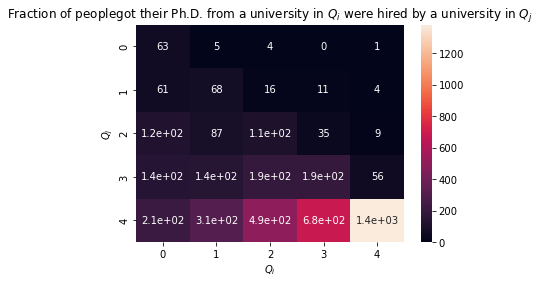

In [43]:
# Fractions of people
data_heatmap = np.zeros((5, 5), dtype=int)
for i in range(5):
    source_universities = df_nodelist[df_nodelist['quintile'] == i].u.values
    for j in range(5):
        target_universities = df_nodelist[df_nodelist['quintile'] == j].u.values
        data_heatmap[i, j] = len(df_edgelist[
            df_edgelist.u.isin(source_universities) & df_edgelist.v.isin(target_universities)])

# Heatmap
sns.heatmap(data_heatmap, annot=True)
plt.xlabel('$Q_i$')
plt.ylabel('$Q_j$')
plt.title('Fraction of peoplegot their Ph.D. from a university in $Q_i$ were hired by a university in $Q_j$')

#### Question 2

We can say that Ph.D. graduates who are hired as professors usually go to universities that are better than the universities where they were trained.

### Task 3 — (25 points)

Let the "source university" of a person be the university at which the person got their Ph.D., and let their "target university" be the university at which they were hired after their Ph.D.


1. For each hiring decision $(u, v)$, let the score gain ($d$) be defined as the difference between the scores of the target university and the source university (target university score minus source university score; see hint for example). Calculate the average difference for men ($\bar{d_{M}}$) and for women ($\bar{d_{F}}$) in the dataset. Determine whether the difference between these two averages ($\bar{d_{M}}$ and $\bar{d_{F}}$) is statistically significant.

2. **/True or false:/** Is the following statement **true** or **false**? Justify your answer. **"The results you obtained in Task 3.1 do not refute the hypothesis that women are disadvantaged in the faculty hiring process."**

3. For each quintile $Q$ from Task 2.1, calculate the following: **(a)** the percentage of women among hiring decisions $(u, v)$ with $u \in Q$ ; and **b)** the average score gain for hiring decisions $(u, v)$ with $u \in Q$.

4. **/Discuss:/** Considering the results obtained in Task 3.3, why is comparing the average score gain for men ($\bar{d_{M}}$) and women ($\bar{d_{F}}$) insufficient for determining the causal effect of gender on score gain?

5. Use `statsmodels` to run a linear regression where hiring decisions (edges of the hiring network) are the data points, gender and source-university score are the predictors, and score gain is the outcome. Report the summary of your model.

6. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"The results you obtained in Task 3.5 suggest that academic hiring decisions are unfair to women."**

---
**Hint** — The university with the best score is Stanford University (score 100), and the university with the 10th best score is the University of Washington (score 95.26). If someone was trained at Stanford and then got a job at the University of Washington, their score gain is $95.26 - 100 = -4.74$.

#### Question 1

In [45]:
# Score difference
df_edgelist['gain'] = df_target.score - df_source.score
df_edgelist

,u,v,gender,gain
0,1,1,F,0.000000
1,1,1,F,0.000000
2,1,1,F,0.000000
3,1,1,M,0.000000
4,1,1,M,0.000000
...,...,...,...,...
4383,194,194,M,11.147825
4384,198,198,M,12.258274
4385,200,200,F,12.762039
4386,204,204,M,15.540870


In [46]:
# Get gains for men and women
df_edgelist_men = df_edgelist[df_edgelist['gender'] == 'M']
df_edgelist_women = df_edgelist[df_edgelist['gender'] == 'F']

In [48]:
# Average for men
df_edgelist_men.gain.describe()

count    2379.000000
mean      -24.147840
std        19.903043
min       -73.852987
25%       -38.047776
50%       -20.486431
75%        -8.244407
max        30.686312
Name: gain, dtype: float64

In [49]:
# Average for women
df_edgelist_women.gain.describe()

count    2009.000000
mean      -24.144915
std        19.309501
min       -73.435892
25%       -36.823574
50%       -18.682628
75%        -8.287742
max        24.565300
Name: gain, dtype: float64

In [50]:
# T-test for the means
stats.ttest_ind(df_edgelist_men.gain, df_edgelist_women.gain)

Ttest_indResult(statistic=-0.004917039435995291, pvalue=0.9960770095765794)

The p-value is higher than 5% so we keep the null hypothesis and can say that the difference is not statistically significant.

#### Question 2

Since there is no significant difference between the means, we can say the results do not show that women are disadvantaged in the faculty hiring process. The answer is **True**.

## Part 2 — Tennis interviews

For the second part of the exam, you will work with text data extracted from questions asked during post-match tennis interviews and from
TV commentary done during the tennis match.


Examples of interview questions:

> That last set seemed like a faultless performance. Is that the way you saw it?

> How disappointing is that loss for you?

> As a spectator, would you rather watch a guy with big aces or a match with lots of rallies?

Example of commentary text:

>  Serena is desperate to shake herself into action. She lets out an almighty shriek when she goes 30-15 up, but Azarenka responds with a brilliant forehand. The level of Williams' scream goes up and up during the next point, and she lets out another roar when she belts a forehand cross court win the point. She wraps the game up next time round, and she looked something like back to her best there!


## Files (in the `data` folder)

- `questions.tsv.gz` a tab-separated compressed file containing interview questions
and some metadata. We refer to this dataset as the "questions dataset."
Each row contains a question made to a specific player after a match.
The file has the following columns:
    - `questions` — the text of the question asked; **Note that you will never be asked to use this row; it is merely meant to help you understand the data better**.
    - `gender` — the gender of the player;
    - `ranking` — the ranking of the player at the time;
    - `similarity` — this column will be explained later in the exam.

- `commentary.tsv.gz` a tab-separated compressed file containing TV commentary done during
the tennis match. We refer to this dataset as the "commentary dataset." Each line contains
a piece of commentary done in a tennis match.
The file has the following columns:
    - `commentary` — the text of the commentary; **Note that you will never be asked to use this row; it is merely meant to help you understand the data better**.
    - `gender` — the gender of the players in the match;

- `TFIDF.npz`, a file containing 2D numpy arrays saved in the `.npz` format that
will be used in Task 4.

Both datasets are **balanced regarding gender,** i.e., they have the same number of rows about men as about women.


Commentary text, as well as interview questions, have been preprocessed to make your life easier, as follows:

- We replaced all words starting with upper-case letters with the special string `'--ENT--'`. This was done to remove personal names (e.g., Alice, Bob), which could help predict whether the text is associated with a male or a female tennis player.
- We removed the first word in each sentence. This was done because, for the first word of each sentence, it is difficult to know whether it is a personal name or simply a regular word.
- We replaced all gendered pronouns in the text (he/him/his and she/her/hers) with the special string `'--PRON--'`. This, too, was done because these words would make it easy to predict whether the text is associated with a male or a female tennis player.
- We removed punctuation and stop words (to reduce the dimensionality of the data).

The above example commentary text thus appears as follows in the data provided to you:

> desperate shake action lets almighty shriek --PRON-- goes 30 15 --ENT-- responds brilliant forehand level --ENT-- scream goes point --PRON-- lets roar --PRON-- belts forehand cross court win point wraps game time round --PRON-- looked like --PRON-- best

We also provide some code for loading and displaying the dataset:

In [19]:
# Part 2
df_questions = pd.read_csv("./data/part-2/questions.tsv.gz", sep="\t", compression="infer")
df_commentary = pd.read_csv("./data/part-2/commentary.tsv.gz", sep="\t", compression="infer")

In [20]:
df_questions

,questions,ranking,similarity,gender
0,successful --ENT-- today year,366,0.431568,F
1,players player admire growing,352,0.247449,F
2,shot clock thing countdown,441,0.702559,F
3,birthplace --ENT-- place lot --ENT-- --ENT-- b...,760,0.270464,F
4,--ENT-- match today,99,0.322474,F
...,...,...,...,...
2995,thing talking yesterday court adjusted --ENT--...,825,0.962224,M
2996,second set seventh game points drew bit reacti...,957,0.534116,M
2997,expect fined touching official shoving officia...,348,0.611607,M
2998,notion squash shots occasionally played shots ...,770,0.502502,M


In [21]:
df_commentary

,commentary,gender
0,restarts contest foot --ENT-- reaches 30 15 he...,M
1,start --ENT-- --ENT-- moves 15 0 ahead --ENT--...,M
2,continues struggle --ENT-- serve proves diffic...,M
3,hold 15 begin second set NoDjo gasp break --PR...,M
4,hold --ENT-- --PRON-- wo fight easily competit...,M
...,...,...
2995,good response losing set --ENT-- wins --PRON--...,F
2996,looks strong --PRON-- makes series stunning re...,F
2997,manages wrong foot --ENT-- forehand line leavi...,F
2998,benefiting mistake --ENT-- 15 15 --ENT-- contr...,F


### Task 4  (20 points)

Your goal now is to investigate whether there is gender bias in the questions being asked to female vs. male players, i.e., whether men vs. women are asked different questions on average. You start your analysis with a classification framing.


To make your life easier, we already provided a TF-IDF matrix for each dataset (`commentary.tsv.gz` and `questions.tsv.gz`) and with code to load these matrices (which are numpy arrays).

- Each row in each matrix $M$ corresponds to a row in the corresponding dataframe, i.e., each row corresponds to a different question or a different piece of TV commentary.
- Each column in each matrix corresponds to a different word from the vocabulary.
- Each position $(i,j)$ in the matrix contains the TF-IDF score for word $j$ from the vocabulary in question or commentary $i$. That is, each term $M[i,j]$ corresponds to the term frequency (TF) of word $j$ in text $i$, multiplied by the inverse document frequency (IDF) of word $j$:


$$M[i,j] = \text{TF}(i,j) * \text{IDF}(j)$$


1. **/Multiple Choice:/** Which of the following is the correct way to calculate the term frequency and the inverse document frequency? Justify your answer, explaining what each of the two components should capture.
    - Option A:

    $$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in all documents} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents the $j$-th word occurs in}}{\text{number of documents}}$$

    - Option B:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th document} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents the $j$-th word occurs in}}{\text{number of documents}}$$

    - Option C:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in all documents} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents}}{\text{number of documents the $j$-th word occurs in}}$$

    - Option D:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th document} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents}}{\text{number of documents the $j$-th word occurs in}}$$



2. Leveraging the matrices described above, train two logistic regression classifiers (one for interview questions, the other for TV commentary) that use the TF-IDF vectors as features to predict the gender of the athletes. You should split each dataset into training and test sets using sklearn (see [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) using parameters `test_size=0.4` and `random_state=42`. You should use sklearn's logistic regression model (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)) using parameters `C=10` (which controls regularization) and `max_iter=2000`. For each dataset, train the model on the training set (with 60% of the data) and report the accuracy on the test set (with 40% of the data).

3. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"Based on the outcome of Task 4.2, the text from tennis commentary text is more gender-biased than post-match questions."**

4. The parameter `C` above controls a regularization penalty. The lower `C`, the stronger the regularization penalty (caveat: sklearn’s convention is the reverse of the convention you saw in class, where a *higher* $\lambda$ parameter meant a stronger regularization penalty ). For the questions dataset, re-run the classification task using the same setup as in Task 4.2, but now with `C=2000`. Report the accuracy.

5. **/Discuss:/** Explain why increasing `C` changed the results.


#### Question 1

The correct option is the option **D**.

- The **term frequency** is the number of times that term j occurs in document i.
- The **inverse document** frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents.

#### Question 2

In [22]:
tmp = np.load("./data/part-2/TFIDF.npz")
TFIDF_questions = tmp['questions']
TFIDF_commentary = tmp['commentary']

In [23]:
# Split dataset
y_questions = (df_questions['gender'] == 'M').astype(int)
X_train_questions, X_test_questions, y_train_questions, y_test_questions = \
    train_test_split(TFIDF_questions, y_questions, test_size=0.4, random_state=42)

# Train classifier
clf = lm.LogisticRegression(random_state=42, C=10, max_iter=2000)
clf.fit(X_train_questions, y_train_questions)

# Validate
y_pred_questions = clf.predict(X_test_questions)

# Calculate accuracy
accuracy_questions = accuracy_score(y_test_questions, y_pred_questions)
print(f'Accuracy for questions: {accuracy_questions:.3f}')

Accuracy for questions: 0.711


In [24]:
# Split dataset
y_commentary = (df_commentary['gender'] == 'M').astype(int)
X_train_commentary, X_test_commentary, y_train_commentary, y_test_commentary = \
    train_test_split(TFIDF_commentary, y_commentary, test_size=0.4, random_state=42)

# Train classifier
clf = lm.LogisticRegression(random_state=42, C=10, max_iter=2000)
clf.fit(X_train_commentary, y_train_commentary)

# Validate
y_pred_commentary = clf.predict(X_test_commentary)

# Calculate accuracy
accuracy_commentary = accuracy_score(y_test_commentary, y_pred_commentary)
print(f'Accuracy for commentary: {accuracy_commentary:.3f}')

Accuracy for commentary: 0.513


#### Question 3

The accuracy is higher for questions. So, it is easier to determine the gender using the questions rather than using the commentary. So, the text from tennis post-match questions is more gender-biased than commentary text. The answer is **False**.

#### Question 4

In [25]:
# Split dataset
y_questions = (df_questions['gender'] == 'M').astype(int)
X_train_questions, X_test_questions, y_train_questions, y_test_questions = \
    train_test_split(TFIDF_questions, y_questions, test_size=0.4, random_state=42)

# Train classifier
clf = lm.LogisticRegression(random_state=42, C=2000, max_iter=2000)
clf.fit(X_train_questions, y_train_questions)

# Validate
y_pred_questions = clf.predict(X_test_questions)

# Calculate accuracy
accuracy_questions = accuracy_score(y_test_questions, y_pred_questions)
print(f'Accuracy for questions: {accuracy_questions:.3f}')

Accuracy for questions: 0.689


In [26]:
# Split dataset
y_commentary = (df_commentary['gender'] == 'M').astype(int)
X_train_commentary, X_test_commentary, y_train_commentary, y_test_commentary = \
    train_test_split(TFIDF_commentary, y_commentary, test_size=0.4, random_state=42)

# Train classifier
clf = lm.LogisticRegression(random_state=42, C=2000, max_iter=2000)
clf.fit(X_train_commentary, y_train_commentary)

# Validate
y_pred_commentary = clf.predict(X_test_commentary)

# Calculate accuracy
accuracy_commentary = accuracy_score(y_test_commentary, y_pred_commentary)
print(f'Accuracy for commentary: {accuracy_commentary:.3f}')

Accuracy for commentary: 0.560


#### Question 5

The aim of the regularizer is to avoid overfitting. So, if we increase `C`, we give less importance to the regularizer. So, with a big `C` (e.g. 2000), we observe overfitting and thus the accuracy is lower.

### Task 5 — (20 pts)

You will now further inspect whether there is gender bias in the interview questions using an observational study framing. For this task, you will use the column `similarity` provided in the questions dataframe. This column captures how similar each question is to tennis-related text, i.e., a higher score indicates that the question is more about the topic of tennis. In contrast, a lower score means that the question may be personal or about other subjects.

1. Using `statsmodels`, run a linear regression with `similarity` as the predictor and `gender` as the outcome. Report the summary of your model.

2. **/True or false:/** According to the previous analysis, determine if the following statement is **true** or **false** and justify your answer. **"Men are asked questions unrelated to tennis more often than women."**

3. The ranking of players is a potential confounder here. We do not know whether the male and female players in the dataset have similar rankings. In that context, compute the average ranking for men and women. Determine if the difference is statistically significant. Additionally, create a scatter plot showing the relationship between ranking (on the y-axis) and similarity (in the x-axis) and compute Spearman's rank-correlation coefficient between `ranking` and `similarity`.

4. **/True or false:/** Assume that no variable other than `gender` and `ranking` can have any influence on the `similarity` of each question. Based on the analysis of the previous question, is the following statement **true** or **false**? Justify your answer. **"Ranking is not a worrisome confounder for the regression of Task 5.1."**

#### Question 1

In [27]:
# Add gender_int column
df_questions['gender_int'] = (df_questions['gender'] == 'M').astype(int)
df_questions

,questions,ranking,similarity,gender,gender_int
0,successful --ENT-- today year,366,0.431568,F,0
1,players player admire growing,352,0.247449,F,0
2,shot clock thing countdown,441,0.702559,F,0
3,birthplace --ENT-- place lot --ENT-- --ENT-- b...,760,0.270464,F,0
4,--ENT-- match today,99,0.322474,F,0
...,...,...,...,...,...
2995,thing talking yesterday court adjusted --ENT--...,825,0.962224,M,1
2996,second set seventh game points drew bit reacti...,957,0.534116,M,1
2997,expect fined touching official shoving officia...,348,0.611607,M,1
2998,notion squash shots occasionally played shots ...,770,0.502502,M,1


In [28]:
# Linear regression
mod = smf.ols(formula='similarity ~ C(gender_int)', data=df_questions)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     841.1
Date:                Tue, 25 Jan 2022   Prob (F-statistic):          3.16e-163
Time:                        10:30:01   Log-Likelihood:                 77.527
No. Observations:                3000   AIC:                            -151.1
Df Residuals:                    2998   BIC:                            -139.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3750      0

#### Question 2

The p-value of `gender_int` is lesser than 5% so it is a significant predictor. We have a positive coefficient for the similarity, meaning that the similarity is higher when the gender is higher. Here, women are represented as 0 and men as 1. So, men are asked questions related to tennis more often than women. The answer is **False**.

#### Question 3

In [29]:
# Get ranking for men and women
men_ranking = df_questions[df_questions['gender'] == 'M'].ranking
women_ranking = df_questions[df_questions['gender'] == 'F'].ranking

In [30]:
# Average ranking for men
men_ranking.describe()

count    1537.000000
mean      495.202342
std       289.576069
min         1.000000
25%       246.000000
50%       490.000000
75%       742.000000
max       999.000000
Name: ranking, dtype: float64

In [31]:
# Average ranking for women
women_ranking.describe()

count    1463.000000
mean      503.617908
std       289.348305
min         1.000000
25%       253.000000
50%       496.000000
75%       763.500000
max       999.000000
Name: ranking, dtype: float64

The average ranking is higer for women.

In [32]:
# T-test for the means
stats.ttest_ind(men_ranking, women_ranking)

Ttest_indResult(statistic=-0.7959498763790183, pvalue=0.42612418722112966)

The p-value is higher than 5% so we keep the null hypothesis and can say that the difference is not statistically significant.

Text(0.5, 1.0, 'Relationship between ranking and similarity')

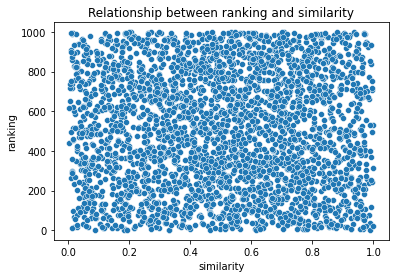

In [33]:
# Relationship between ranking and similarity
sns.scatterplot(x='similarity', y='ranking', data=df_questions)
plt.title('Relationship between ranking and similarity')

In [34]:
# Spearman correlation coefficient
stats.spearmanr(df_questions['ranking'], df_questions['similarity'])

SpearmanrResult(correlation=-0.00793480965681015, pvalue=0.663973935968952)

#### Question 4

The p-value is higher than 5% so we keep the null hypothesis and can say that `ranking` and `similarity` seem to be uncorrelated. So, ranking is not a worrisome confounder for the regression of Task 5.1. The answer is **True**.